In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pandas.plotting import parallel_coordinates
from scipy.stats import randint
from helper_functions import *
import seaborn as sns
import matplotlib.ticker as mticker

In [31]:
lg_results = pd.read_csv("../output/logistic_regression/logistic_regression_test_predictions.csv")

xgb_results = pd.read_csv("../output/xgb/xgb_test_predictions.csv")

rf_results = pd.read_csv("../output/rf/rf_test_predictions.csv")


lg_results["period"] = pd.to_datetime(lg_results["period"])
xgb_results["period"] = pd.to_datetime(xgb_results["period"])
rf_results["period"] = pd.to_datetime(rf_results["period"])


In [13]:
# evaluation function with customizable thresholds for cutoffs
def evaluate_model(df, model_name, lower_threshold=0.4, upper_threshold=0.6):
    metrics = {}

    # AUC
    metrics['AUC'] = roc_auc_score(df['y_true'], df['y_pred_prob'])

    # AUC per year
    df['year'] = pd.to_datetime(df['period']).dt.year
    auc_per_year = df.groupby('year').apply(
        lambda x: roc_auc_score(x['y_true'], x['y_pred_prob']) if len(x['y_true'].unique()) > 1 else np.nan
    )
    metrics['AUC_per_year'] = auc_per_year.to_dict()

    # Metrics for p=0.5 cutoff
    df['y_pred_0.5'] = (df['y_pred_prob'] >= 0.5).astype(int)
    metrics['Accuracy_0.5'] = accuracy_score(df['y_true'], df['y_pred_0.5'])
    metrics['Precision_0.5'] = precision_score(df['y_true'], df['y_pred_0.5'])
    metrics['Recall_0.5'] = recall_score(df['y_true'], df['y_pred_0.5'])
    metrics['F1_0.5'] = f1_score(df['y_true'], df['y_pred_0.5'])

    # Metrics for custom thresholds
    df_cutoff = df[(df['y_pred_prob'] < lower_threshold) | (df['y_pred_prob'] > upper_threshold)].copy()
    df_cutoff['y_pred_cutoff'] = (df_cutoff['y_pred_prob'] > upper_threshold).astype(int)
    if not df_cutoff.empty:
        metrics['Accuracy_cutoff'] = accuracy_score(df_cutoff['y_true'], df_cutoff['y_pred_cutoff'])
        metrics['Precision_cutoff'] = precision_score(df_cutoff['y_true'], df_cutoff['y_pred_cutoff'])
        metrics['Recall_cutoff'] = recall_score(df_cutoff['y_true'], df_cutoff['y_pred_cutoff'])
        metrics['F1_cutoff'] = f1_score(df_cutoff['y_true'], df_cutoff['y_pred_cutoff'])
    else:
        metrics['Accuracy_cutoff'] = np.nan
        metrics['Precision_cutoff'] = np.nan
        metrics['Recall_cutoff'] = np.nan
        metrics['F1_cutoff'] = np.nan

    print(f"Evaluation for {model_name}:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print("\n")


# Function to modify bar plot for side-by-side bars with annotations
def plot_bar(df, model_name):
    # Bin predicted probabilities into intervals
    bins = np.linspace(0, 1, 11)
    df['prob_bin'] = pd.cut(df['y_pred_prob'], bins, include_lowest=False)
    
    # Count occurrences of true labels in each bin
    bar_data = df.groupby(['prob_bin', 'y_true']).size().unstack(fill_value=0)
    
    # Plot the bar chart with side-by-side bars
    ax = bar_data.plot(kind='bar', figsize=(12, 6), alpha=0.7, width=0.8)
    #plt.title(f"{model_name} - Predicted Probabilities vs True Labels (Side-by-Side Bar Plot)")
    plt.xlabel("Predicted Probability Bins")
    plt.ylabel("Count of True Labels")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend(title="True Label", loc='upper right')
    
    # Add annotations
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 5),
            textcoords='offset points'
        )
    
    plt.show()


Evaluation for Random Forest:
AUC: 0.6621995306130851
AUC_per_year: {2021: 0.6177036756347102, 2022: 0.7039465601965601, 2023: 0.5908764367816093}
Accuracy_0.5: 0.6044871794871794
Precision_0.5: 0.5717488789237668
Recall_0.5: 0.6845637583892618
F1_0.5: 0.6230910201588271
Accuracy_cutoff: 0.7139479905437353
Precision_cutoff: 0.6814159292035398
Recall_cutoff: 0.9467213114754098
F1_cutoff: 0.7924528301886793




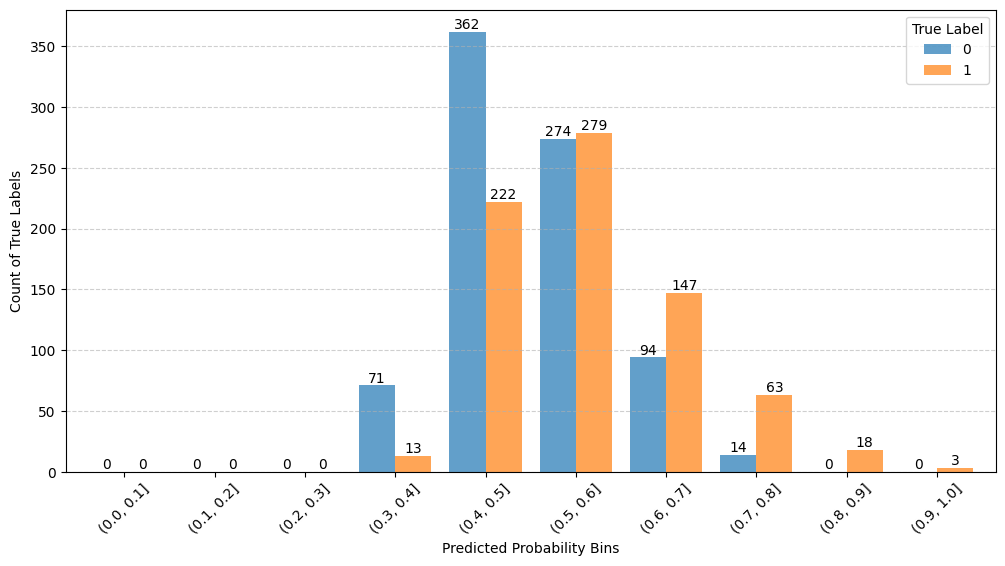

In [14]:
evaluate_model(rf_results, "Random Forest", 0.4, 0.6)
plot_bar(rf_results, "Random Forest")

Evaluation for XGBoost:
AUC: 0.6810062996664882
AUC_per_year: {2021: 0.6476544145509662, 2022: 0.7121160933660934, 2023: 0.5801005747126436}
Accuracy_0.5: 0.6326923076923077
Precision_0.5: 0.6360759493670886
Recall_0.5: 0.5395973154362416
F1_0.5: 0.5838779956427015
Accuracy_cutoff: 0.7002398081534772
Precision_cutoff: 0.7333333333333333
Recall_cutoff: 0.4647887323943662
F1_cutoff: 0.5689655172413793




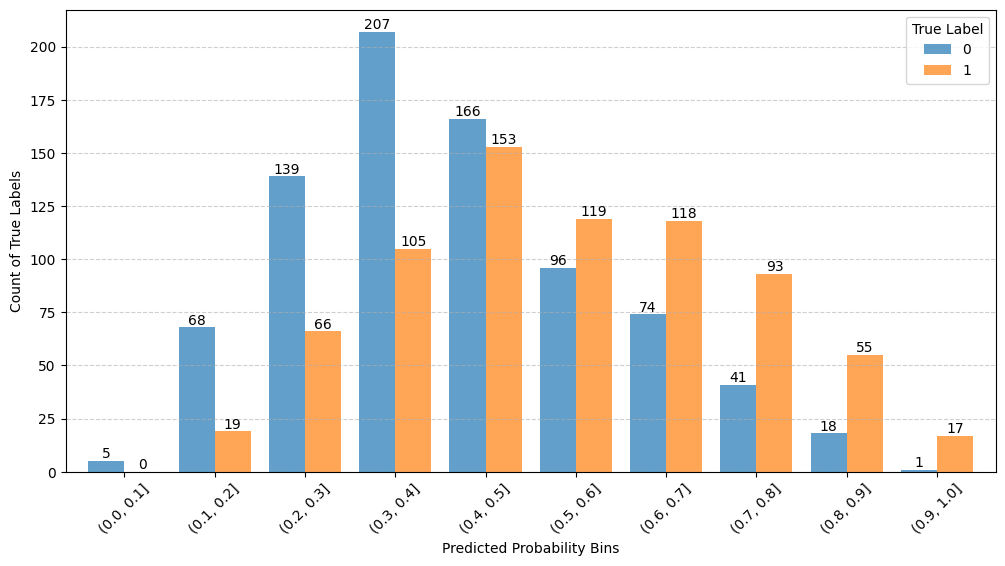

In [17]:
evaluate_model(xgb_results, "XGBoost", 0.4, 0.7)
plot_bar(xgb_results, "XGBoost")

Evaluation for Logistic Regression:
AUC: 0.6030790134639931
AUC_per_year: {2021: 0.5643728685107996, 2022: 0.6273034398034398, 2023: 0.5614224137931034}
Accuracy_0.5: 0.5442307692307692
Precision_0.5: 0.5135350318471338
Recall_0.5: 0.8657718120805369
F1_0.5: 0.6446776611694153
Accuracy_cutoff: 0.5669050051072523
Precision_cutoff: 0.541371158392435
Recall_cutoff: 0.9271255060728745
F1_cutoff: 0.6835820895522388




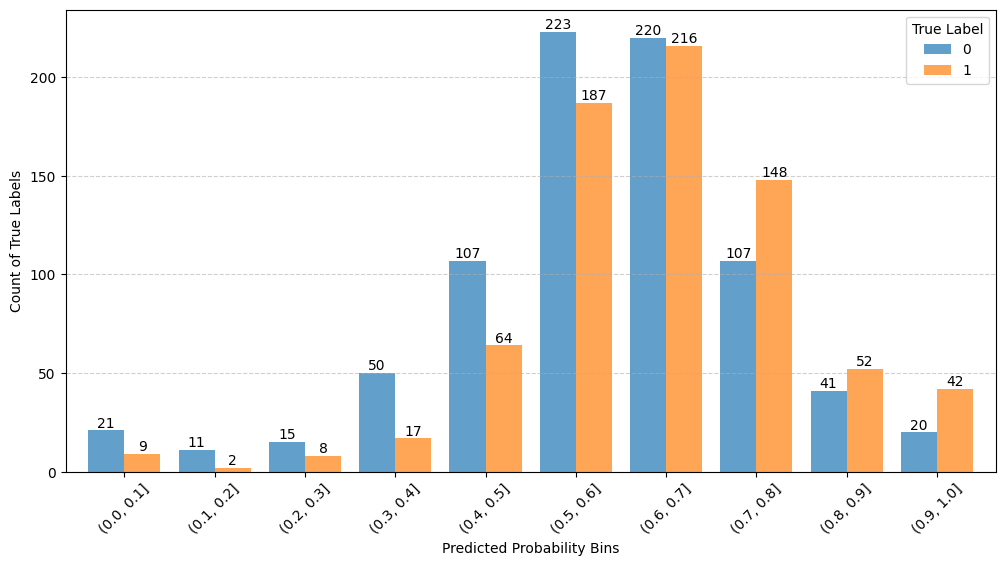

In [16]:
evaluate_model(lg_results, "Logistic Regression", 0.4, 0.6)
plot_bar(lg_results, "Logistic Regression")


**Robustness Check of Recursive Feature Elimination**

In [32]:
rf1 = pd.read_csv("../feature_selection/1_iteration/rf/rf_test_predictions.csv")
rf2 = pd.read_csv("../feature_selection/2_iteration/rf/rf_test_predictions.csv")
rf3 = pd.read_csv("../feature_selection/3_iteration/rf/rf_test_predictions.csv")

xgb1 = pd.read_csv("../feature_selection/1_iteration/xgb/xgb_test_predictions.csv")
xgb2 = pd.read_csv("../feature_selection/2_iteration/xgb/xgb_test_predictions.csv")
xgb3 = pd.read_csv("../feature_selection/3_iteration/xgb/xgb_test_predictions.csv")

rf1["period"] = pd.to_datetime(rf1["period"])
rf2["period"] = pd.to_datetime(rf2["period"])
rf3["period"] = pd.to_datetime(rf3["period"])

xgb1["period"] = pd.to_datetime(xgb1["period"])
xgb2["period"] = pd.to_datetime(xgb2["period"])
xgb3["period"] = pd.to_datetime(xgb3["period"])

In [34]:
evaluate_model(rf1, "rf1", 0.4, 0.6)
evaluate_model(rf2, "rf2", 0.4, 0.6)
evaluate_model(rf3, "rf3", 0.4, 0.6)

evaluate_model(xgb1, "xgb1", 0.4, 0.6)
evaluate_model(xgb2, "xgb2", 0.4, 0.6)
evaluate_model(xgb3, "xgb3", 0.4, 0.6)

Evaluation for rf1:
AUC: 0.6462140239634373
AUC_per_year: {2021: 0.5947859037514209, 2022: 0.6910089066339066, 2023: 0.595905172413793}
Accuracy_0.5: 0.5820512820512821
Precision_0.5: 0.5438265786993403
Recall_0.5: 0.774496644295302
F1_0.5: 0.6389811738648948
Accuracy_cutoff: 0.6782006920415224
Precision_cutoff: 0.6782006920415224
Recall_cutoff: 1.0
F1_cutoff: 0.8082474226804124


Evaluation for rf2:
AUC: 0.6544455881747437
AUC_per_year: {2021: 0.6031148162182645, 2022: 0.7018734643734644, 2023: 0.5894396551724137}
Accuracy_0.5: 0.5955128205128205
Precision_0.5: 0.5590062111801242
Recall_0.5: 0.7248322147651006
F1_0.5: 0.6312098188194039
Accuracy_cutoff: 0.6859756097560976
Precision_cutoff: 0.6719745222929936
Recall_cutoff: 1.0
F1_cutoff: 0.8038095238095239


Evaluation for rf3:
AUC: 0.6546794581463334
AUC_per_year: {2021: 0.6016976127320954, 2022: 0.7040770884520885, 2023: 0.6052442528735632}
Accuracy_0.5: 0.5858974358974359
Precision_0.5: 0.5515088449531738
Recall_0.5: 0.711409395973